In [1]:
from minigraphs.mcmc import SimulatedAnnealing
from minigraphs.metrics import spectral_radius
from minigraphs.mcmc.chains import Chain
from typing import Deque
from collections import deque, Counter
import networkx as nx
import random

class RandomizedSet:
    def __init__(self, random_state: random.Random):
        self.val_to_index = {}
        self.values = []
        self.random = random_state

    def insert(self, val: int) -> bool:
        if val in self.val_to_index:
            return False
        self.val_to_index[val] = len(self.values)
        self.values.append(val)
        return True

    def remove(self, val: int) -> bool:
        if val not in self.val_to_index:
            return False
        idx = self.val_to_index[val]
        last_val = self.values[-1]
        self.values[idx] = last_val
        self.val_to_index[last_val] = idx
        self.values.pop()
        del self.val_to_index[val]
        return True

    def getRandom(self) -> int:
        return self.random.choice(self.values)
    
    def __bool__(self):
        return bool(self.values)

class CoarseningChain(Chain):
    """A graph chain implementing node coarsening.
    """

    def __init__(self, graph: nx.Graph, n_groups: int, seed: int=None):
        super().__init__(seed=seed)
        self.graph = graph 
        self.n_groups = n_groups
        self.groups = range(n_groups)

        # Generate coarsened graph.
        # Nodes hold references to sets containing the nodes encapsulated by the super nodes
        # Edges contain scalars reflecting the number of edges a super edge represents
        self.graph_coarse: nx.Graph = nx.complete_graph(self.n_groups)
        nx.set_node_attributes(self.graph_coarse, values = {node: {'nodes': RandomizedSet(self.random)} for node in self.graph_coarse.nodes()})
        nx.set_edge_attributes(self.graph_coarse, name='count', values=0)

        # Randomly allocate nodes to super nodes
        for node in self.graph.nodes():
            # Select a group at random
            group = self.random.choice(self.groups)

            # Store references
            self.graph.nodes[node]['group'] = group 
            self.graph_coarse.nodes[group]['nodes'].insert(node)

        # Identify edges of coarsened graph
        for edge in self.graph.edges():
            # Identify corresponding super edge
            super_edge = tuple((self.graph.nodes[node]['group'] for node in edge))

            if super_edge[0] != super_edge[1]:
                self.graph_coarse.edges[super_edge]['count'] += 1

    @property 
    def state(self) -> nx.Graph:
        """Returns the coarsened graph.
        """
        graph = nx.empty_graph(self.n_groups)
        graph.add_edges_from(((u,v) for (u,v,data) in self.graph_coarse.edges(data=True) if data['count'] > 0))
        
        return graph
    
    def propose(self) -> nx.Graph:
        """Proposes a new graph by randomly moving nodes across super nodes.

        Randomly selects a super node to draw a node and moves it to a random different super node,
        updating the edge counts along the way.
        """
        # Select random group
        old_group = self.random.choice(self.groups)
        nodes: RandomizedSet = self.graph_coarse.nodes[old_group]['nodes']

        if nodes: # Check for nodes in group
            # Select random node
            node = nodes.getRandom()
            neighbors = list(self.graph.neighbors(node))

            if neighbors: # Check for neighbors
                # Select random neighbor
                neighbor = self.random.choice(neighbors)
                new_group = self.graph.nodes[neighbor]['group']

                if old_group != new_group:
                    # Update data.
                    self.change = (node, old_group)
                    self._move_node(node, new_group)

    def _move_node(self, node: int, new_group: int):
        """Moves a node to a new group.
        """
        old_group = self.graph.nodes[node]['group']

        # Update node data
        self.graph.nodes[node]['group'] = new_group
        self.graph_coarse.nodes[old_group]['nodes'].remove(node)
        self.graph_coarse.nodes[new_group]['nodes'].insert(node)

        # Update edge counts
        for neighbor in list(self.graph.neighbors(node)):
            neighbor_group = self.graph.nodes[neighbor]['group']

            # Update edge counts
            if old_group != neighbor_group:
                old_edge = (old_group, neighbor_group)
                self.graph_coarse.edges[old_edge]['count'] -= 1 

            if new_group != neighbor_group:
                new_edge = (new_group, neighbor_group)
                self.graph_coarse.edges[new_edge]['count'] += 1

    def reject(self):
        """Reject the proposed change and reverse the proposed merge.
        """
        # Update node data
        node, old_group = self.change
        self._move_node(node, old_group)


100%|██████████| 5000/5000 [00:12<00:00, 388.05it/s]


<Axes: >

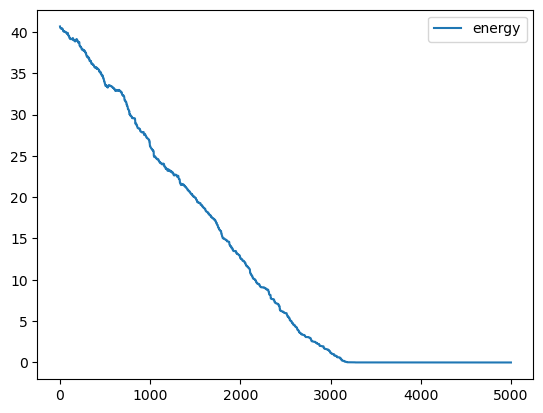

In [18]:

from minigraphs.metrics import graph_spectrum
from minigraphs.data import load_graph
from numpy import abs, exp

hamsterster = load_graph('hamsterster')
chain = CoarseningChain(hamsterster, 100)
schedule = lambda step: exp(step/500)

annealer = SimulatedAnnealing(
    chain, 
    energy = lambda graph: abs(graph_spectrum(graph)[0] - 50),
    schedule=schedule,
    n_steps=5000,
    verbose=True
)

annealer.run()

annealer.history_.plot(y='energy')

In [19]:
graph_spectrum(annealer.best_graph_)

[np.float32(50.000443)]

(np.float64(-1.2099999861725754),
 np.float64(1.2099999957490022),
 np.float64(-1.2099999984312113),
 np.float64(1.2099999834903667))

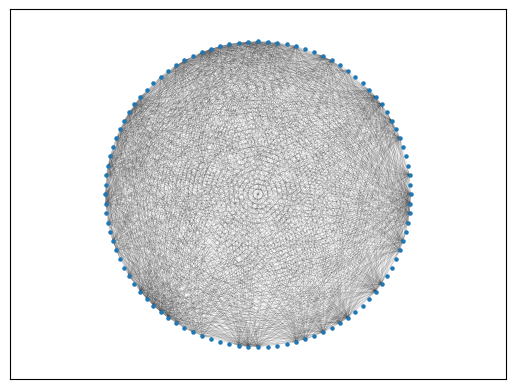

In [ ]:
from minigraphs.inspection import draw_subgraph
import matplotlib.pyplot as plt 

pos = nx.circular_layout(annealer.best_graph_)

nx.draw_networkx_nodes(annealer.best_graph_, pos, node_size=5)
nx.draw_networkx_edges(annealer.best_graph_, pos, width=0.1, alpha=0.5)

plt.gca().axis('equal')


In [ ]:
from minigraphs.simulation import SIRModel
from functools import partial 
from mesa.batchrunner import batch_run
import pandas as pd 
import seaborn as sns 

parameters = {
    'beta' : 
}
results_original = pd.DataFrame(
    batch_run(
        partial(SIRModel, network=hamsterster),
    )
)

0.3086868686868687